In [1]:
import os
import datetime

import sys

sys.path.append("..")
import datetime, time, os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from functions import df_security_code

import tensorflow as tf

#from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras.layers.experimental import preprocessing

mpl.rcParams['figure.figsize'] = (5, 5)
mpl.rcParams['axes.grid'] = False
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


tf.keras.backend.set_floatx('float64')

# Define random seed for whole notebook
RSEED=42

# Data

In [2]:
data = pd.read_csv('../data/data.csv', parse_dates=['Date'],  index_col=[0])
df  = df_security_code(data)
del data

In [3]:
df.columns

Index(['RowId', 'Date', 'SecuritiesCode', 'ExpectedDividend',
       'SupervisionFlag', 'ad_Open', 'ad_High', 'ad_Low', 'ad_Close',
       'ad_Volume', 'ad_Target', 'ad_Close_lag1', 'ad_Close_sma10',
       'logprice_ad_Close', 'detrend_ad_Close', 'trend_ad_Close',
       'season_ad_Close', 'error_ad_Close', 'ad_Open_lag1', 'ad_Open_sma10',
       'logprice_ad_Open', 'detrend_ad_Open', 'trend_ad_Open',
       'season_ad_Open', 'error_ad_Open', 'ad_High_lag1', 'ad_High_sma10',
       'logprice_ad_High', 'detrend_ad_High', 'trend_ad_High',
       'season_ad_High', 'error_ad_High', 'ad_Low_lag1', 'ad_Low_sma10',
       'logprice_ad_Low', 'detrend_ad_Low', 'trend_ad_Low', 'season_ad_Low',
       'error_ad_Low', 'ad_Volume_lag1', 'ad_Volume_sma10', 'RSI', 'Return',
       'macd', 'macd_h', 'macd_s', 'Day', 'Month', 'Year', 'week',
       'Volatility_week', 'Day_sin', 'Day_cos', 'Month_sin', 'Month_cos',
       'Year_sin', 'Year_cos', 'Profit', 'NetSales', 'margin',
       'win_quarter_growt

In [4]:
df.columns

df.drop(['RowId', 'Date', 'SecuritiesCode', 'ExpectedDividend',
       'SupervisionFlag', 'margin_growth', 'win_quarter_growth', 'margin', 'NetSales', 'Profit',
       'Day_cos', 'Year', 'rev_quarter_growth'], axis = 1, inplace=True)

In [5]:
df.head(2)

,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,ad_Target,ad_Close_lag1,ad_Close_sma10,logprice_ad_Close,detrend_ad_Close,...,macd_s,Day,Month,week,Volatility_week,Day_sin,Month_sin,Month_cos,Year_sin,Year_cos
1990468,7010.0,7103.0,6975.0,7097.0,9547600.0,-0.016882,NaN,NaN,8.867427,7097.0,...,107.299482,4.0,1.0,1.0,1.619015,-1.405899e-12,0.046905,-0.998899,0.061933,0.998080
1990469,7090.0,7091.0,7023.0,7049.0,7644000.0,-0.009957,7097.0,NaN,8.860641,7049.0,...,241.726765,5.0,1.0,1.0,1.619015,-1.165928e-11,-0.158971,-0.987283,0.079093,0.996867


In [6]:
df.ad_Close.mean()

7305.0275

In [7]:
def split_train_val_test(df, split=22):
    df.dropna(inplace=True)
    #df_train =  df[:- 4*split]
    #df_val = df[- 4*split : - split]
    #df_test = df[- split : ]
    n = len(df)
    df_train = df[0:int(n*0.7)]
    df_val = df[int(n*0.7):int(n*0.9)]
    df_test = df[int(n*0.9):]


    return df_train, df_val, df_test

In [8]:
train_data, val_data, test_data = split_train_val_test(df=df)
print(df.shape)
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(1185, 50)
(829, 50)
(237, 50)
(119, 50)


In [9]:
#test_data.columns

In [10]:
num_features = train_data.shape[1]

In [11]:
train_df = train_data
val_df = val_data
test_df = test_data

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(829, 50)
(237, 50)
(119, 50)


In [12]:
#train_df[:34]

In [13]:
#train_df[100:100+34]

In [14]:
#train_df[-10:]

# Setup Tensorboard

In [15]:
!rm -rf my_logs/
# Define path for new directory 
root_logdir = os.path.join(os.curdir, "my_logs")

# Define function for creating a new folder for each run
def get_run_logdir():
    run_id = time.strftime('run_%d_%m_%Y-%H_%M_%S')
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

# Create function for using callbacks; "name" should be the name of the model you use
def get_callbacks(name):
    return tf.keras.callbacks.TensorBoard(run_logdir+name, histogram_freq=1)


# Modelling

In [16]:
#normalizer = preprocessing.Normalization()
#normalizer.adapt(np.array(train_df))

scaler = StandardScaler()
scaler.fit(train_df)

StandardScaler()

In [17]:
scaler.mean_

array([   6848.294,    6896.901,    6801.714,    6849.499, 6137400.362,
             0.   ,    6849.281,    6848.423,       8.829,    6849.499,
          6849.913,       0.016,      -0.43 ,    6848.088,    6847.356,
             8.829,    6848.294,    6848.816,       0.021,      -0.543,
          6896.659,    6895.697,       8.836,    6896.901,    6897.319,
             0.017,      -0.435,    6801.514,    6800.885,       8.822,
          6801.714,    6802.299,       0.036,      -0.621, 6142694.813,
       6152317.37 ,      51.129,       1.   ,      21.202,      -5.55 ,
            26.752,      15.932,       6.232,      25.444,       2.575,
            -0.   ,      -0.008,       0.01 ,       0.085,      -0.021])

In [18]:
#normalizer(train_df).numpy().std()

In [19]:
#normalizer(train_df)

In [20]:
# normalize data
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

In [21]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df= train_scaled, # normalizer(train_df),#, train_df,#normalizer(train_df), 
               val_df =  val_scaled, 
               test_df= test_scaled,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_data.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    #self.example = 

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [22]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [23]:
def plot(self, model=None, plot_col='ad_Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model.predict(inputs) # add predict
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [24]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [25]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [26]:
# Plotting function for MSE
def plot_metric(history):
    plt.plot(history.history['root_mean_squared_error'])
    plt.plot(history.history['val_root_mean_squared_error'])
    plt.title('Model RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [27]:
def error_analysis(self, model, col='ad_Close'):

    
    # train
    pred_train = model.predict(train_)
    df_pred_train = pd.DataFrame(scaler.inverse_transform(pred_train[0]))
    df_train_true = df_pred_train.columns = train_df.columns
    #df_pred_train = pred_train[0][:,label_col_index]


    # train _ true
    last_inputs_train, last_labels_train = multi_window.split_window(last_window_train)
    #df_train_true = last_labels_train[0][:,label_col_index]
    df_train_true = pd.DataFrame(last_labels_train[0])
    df_train_true.columns = train_df.columns


    mean_train = df_train_true[col].mean()
    train_rmse = round(np.sqrt(mean_squared_error(df_pred_train[col], df_train_true[col])),3)
    print(f"Train RMSE: {train_rmse}, Mean: {mean_train}  ->  {train_rmse/mean_train*100:.2f}")

    # test - true
    
    pred_test = model.predict(test_)
    df_pred_test = pd.DataFrame(scaler.inverse_transform(pred_test[0]))
    df_pred_test.columns = test_df.columns
    #df_pred_test = scaler.inverse_transform(pred_test[0])[0][:,label_col_index]

    last_inputs_test, last_labels_test = multi_window.split_window(last_window_test)
    #df_test_true = last_labels_test[0][:,3]
    df_test_true = pd.DataFrame(last_labels_test[0])
    df_test_true.columns = test_df.columns

    mean_test = df_test_true[col].mean()
    test_rmse = round(np.sqrt(mean_squared_error(df_pred_test[col], df_test_true[col])),3)
    print(f"Train RMSE: {test_rmse}, Mean: {mean_test}  ->  {test_rmse/mean_test*100:.2f}")

    return [mean_train, train_rmse , mean_test, test_rmse]


WindowGenerator.error_analysis = error_analysis

In [28]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

@property
def separe_map_train(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result



WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
#WindowGenerator.separe_map = separe_map_train


In [29]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
  """early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min'
                                                    )"""

  model.compile(loss='mae', #tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adamax(), # adam
                metrics= [tf.keras.metrics.RootMeanSquaredError()]), #'root_mean_squared_error') #'mse' )# [tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks = get_callbacks(f'{model=}'.split('=')[0])
                      )
  return history

# Multisteps

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-04-29 11:38:36.872643: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-29 11:38:36.872789: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-29 11:38:36.989550: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Total window size: 32
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Label indices: [22 23 24 25 26 27 28 29 30 31]
Label column name(s): None

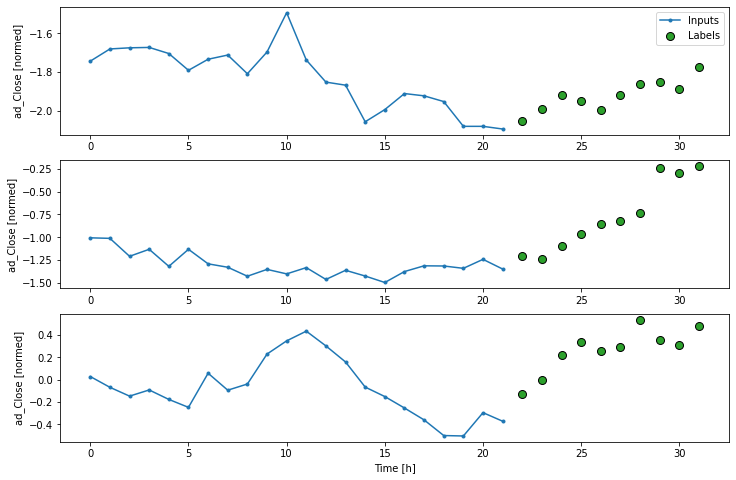

In [30]:
OUT_STEPS = 10 # 1022 # 10
multi_window = WindowGenerator(input_width=22, # 2244, # 22
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)
IPython.display.clear_output()

multi_window.plot()
multi_window

In [31]:
train_ = multi_window.train
test_ = multi_window.test
val_ = multi_window.val

In [32]:
#type(multi_window.train)

In [33]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:multi_window.total_window_size]),
                           np.array(train_df[100:100+multi_window.total_window_size]),
                           np.array(train_df[200:200+multi_window.total_window_size])])


In [34]:
last_window_train = tf.stack([np.array(train_df[- multi_window.total_window_size:])])
last_window_test = tf.stack([np.array(test_df[- multi_window.total_window_size:])])
#last_window_train = tf.stack([np.array(train_df[- multi_window.total_window_size:])])

## - baseline

In [35]:
model_results = {}

In [36]:
#inputs_test.numpy().mean()

In [37]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}
with tf.device('/cpu:0'):
    #inputs, labels = separe_map(multi_window)
    #inputs, labels = multi_window.separe_map
    multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
    multi_val_performance['Last'] = last_baseline.evaluate(val_)
    #multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
    #multi_performance['Last'] = last_baseline.evaluate(test_, verbose=0)
    multi_window.plot(last_baseline)

InvalidArgumentError: Cannot assign a device for operation AssignAddVariableOp: Could not satisfy explicit device specification '' because the node {{colocation_node AssignAddVariableOp}} was colocated with a group of nodes that required incompatible device '/job:localhost/replica:0/task:0/device:GPU:0'. All available devices [/job:localhost/replica:0/task:0/device:CPU:0, /job:localhost/replica:0/task:0/device:GPU:0]. 
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=2 requested_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' assigned_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' resource_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
ReadVariableOp: GPU CPU 
AssignAddVariableOp: CPU 
_Arg: GPU CPU 

Colocation members, user-requested devices, and framework assigned devices, if any:
  assignaddvariableop_resource (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  AssignAddVariableOp (AssignAddVariableOp) 
  div_no_nan/ReadVariableOp (ReadVariableOp) 

	 [[{{node AssignAddVariableOp}}]] [Op:__inference_test_function_678]

In [ ]:
model_results['baseline'] = multi_window.error_analysis(last_baseline)

In [ ]:
# Save the entire small model as a SavedModel.
!mkdir -p saved_model

last_baseline.save('saved_model/baseline_model')

## - linear

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    #tf.keras.layers.Normalization(mean=1.3008788e-06, variance=0.989949),   # including normalization
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    #tf.keras.layers.Normalization(),#,mean=1.3008788e-06, variance=0.989949),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer='uniform'), #tf.initializers.zeros()
    #tf.keras.layers.Normalization(),
    # Shape => [batch, out_steps, features]
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
with tf.device('/cpu:0'):
    history = compile_and_fit(multi_linear_model, multi_window)
    #inputs, labels = multi_window.separe_map

    IPython.display.clear_output()
    #multi_val_performance['Linear'] = multi_linear_model.evaluate(inputs_example, labels_example)
    #multi_val_performance['Linear'] = multi_linear_model.evaluate(val_)
    #multi_performance['Linear'] = multi_linear_model.evaluate(test_, verbose=0)
    #multi_performance['Linear'] = multi_linear_model.evaluate(inputs_test, labels_test, verbose=0)
    multi_window.plot(multi_linear_model)

In [ ]:
#model_results['linear'] = multi_window.error_analysis(last_baseline)

In [ ]:
multi_linear_model.summary()

In [ ]:
#y_train = multi_linear_model.evaluate(multi_window.train)
#y_test = multi_linear_model.evaluate(multi_window.val)

In [ ]:
plot_loss(history)

In [ ]:
plot_metric(history)

In [ ]:
hist_lin = pd.DataFrame(history.history)
#hist_lin

In [ ]:
train_

In [ ]:
pred_train = multi_linear_model.predict(train_)

In [ ]:
len(pred_train)

In [ ]:
len(pred_train[0])

In [ ]:
#pred_train[0]

In [ ]:
arr = scaler.inverse_transform(pred_train[0])

In [ ]:
arr[:,3].mean()

In [ ]:
df_pred_train = pd.DataFrame(scaler.inverse_transform(pred_train[0]))
df_pred_train.columns = train_df.columns
#df_pred_train


In [ ]:
last_inputs, last_labels = multi_window.split_window(last_window_train)

In [ ]:
len(last_labels)

In [ ]:
#df_train2 = pd.DataFrame(scaler.inverse_transform(last_labels[0]))
df_train2 = pd.DataFrame(last_labels[0])
df_train2.columns = train_df.columns
#df_train2

In [ ]:
# plot
#df_pred_train.ad_Close
#df_train2.ad_Close
plt.scatter(multi_window.label_indices, df_pred_train.ad_Close)
plt.scatter(multi_window.label_indices, df_train2.ad_Close, color = 'red')

In [ ]:
multi_window.error_analysis(multi_linear_model)

In [ ]:
multi_linear_model.save('saved_model/linear_model')

In [ ]:
"""
    
# train
pred_train = multi_linear_model.predict(train_)
df_pred_train = pd.DataFrame(scaler.inverse_transform(pred_train[0]))
df_pred_train.columns = train_df.columns
#display(df_pred_train)

    # train _ true
last_inputs_train, last_labels_train = multi_window.split_window(last_window_train)
df_train_true = pd.DataFrame(last_labels_train[0])
df_train_true.columns = train_df.columns
#display(df_train_true)
    # train

train_rmse = round(np.sqrt(mean_squared_error(df_pred_train.ad_Close, df_train_true.ad_Close)),3)
print(f"Train RMSE: {train_rmse}")

    # test - true
last_inputs_test, last_labels_test = multi_window.split_window(last_window_test)"""

## - lstm

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    #tf.keras.layers.Normalization(axis=None), #added
    #tf.keras.layer.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer='uniform'),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
with tf.device('/cpu:0'):
    history = compile_and_fit(multi_lstm_model, multi_window)

    IPython.display.clear_output()
    #inputs, labels = multi_window.separe_map
    #multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
    #multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
    multi_window.plot(multi_lstm_model)

In [ ]:
plot_loss(history)

In [ ]:
plot_metric(history)

In [ ]:
#model_results['LSTM'] = multi_window.error_analysis(multi_lstm_model)

In [ ]:
multi_lstm_model.save('saved_model/lstm_model')

In [ ]:
model_results

In [ ]:
hist_lstm = pd.DataFrame(history.history)


In [ ]:
cols = ['mean_train', 'train_rmse' , 'mean_test', 'test_rmse']

In [ ]:
results = pd.DataFrame(model_results).T
results.columns = cols
results['train%'] = round(results.train_rmse / results.mean_train*100,2)
results['test%'] = round(results.test_rmse / results.mean_test*100, 2)
results